Import
Import the neccesary libraries to be able to find a baseline model, as well as add features
Goal: leave this section with a dataframe ready to prepare.

The ad hoc part includes summarizing your data as you read it in and begin to explore, look at the first few rows, data types, summary stats, column names, shape of the data frame, etc.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LassoCV



plt.rc("axes.spines", top=False, right=False)


import wrangle
import split_scale
import evaluate
import prep
import explore
import model

In [2]:
from env import host, user, password

Prep
Goal: leave this section with a dataset that is ready to be analyzed. Data types are appropriate, missing values have been addressed, as have any data integrity issues.

In [3]:
#data for baseline model
df_base=wrangle.get_data_from_mysql()

In [4]:
df_base.head()

,transactiondate,id,bathrooms,bedrooms,lotsizesquarefeet,sqft,tax_value,region_id
0,2017-06-30,1772,2.0,4.0,6211.0,1604.0,498347.0,12447.0
1,2017-06-01,2028,3.0,3.0,9109.0,2384.0,549917.0,12447.0
2,2017-06-01,3273,2.0,3.0,7538.0,1574.0,235272.0,5534.0
3,2017-06-29,3429,2.0,2.0,111564.0,1619.0,340000.0,40227.0
4,2017-06-27,4505,3.0,2.0,10497.0,2408.0,2017254.0,12447.0


In [5]:
df_tax = wrangle.taxes()

In [6]:
df_tax.head()

,tax_value,fips,taxamount,tax_rate
0,498347.0,6037.0,6089.82,0.0122
1,549917.0,6037.0,6679.55,0.0121
2,235272.0,6037.0,3876.31,0.0165
3,340000.0,6037.0,4206.15,0.0124
4,2017254.0,6037.0,24353.42,0.0121


clean baseline data to only include: bedrooms, bathrooms, and squarefeet

In [7]:
df_base= prep.base_clean(df_base)

Clean up of tax information and acquiring county names based on fips field

In [8]:
df_tax= prep.tax_data_clean(df_tax)

In [34]:
df_tax.head()

,tax_value,fips,taxamount,tax_rate,county
0,498347.0,6037.0,6089.82,0.0122,Los Angles
1,549917.0,6037.0,6679.55,0.0121,Los Angles
2,235272.0,6037.0,3876.31,0.0165,Los Angles
3,340000.0,6037.0,4206.15,0.0124,Los Angles
4,2017254.0,6037.0,24353.42,0.0121,Los Angles


SPLIT & SCALE:

Goal: leave this section with 2 dataframes (train & test) and scaled data

In [ ]:
train, test= split_scale.split_my_data(df_base, train_ratio=0.8, seed=123)

In [ ]:
#labeling the train and test data
X_train = train.drop(columns='tax_value')
y_train = train[['tax_value']]
X_test = test.drop(columns='tax_value')
y_test = test[['tax_value']]

DATA EXPLORATION

Goal: Address each of the questions you posed in your planning and brainstorming and any others you have come up with along the way through visual or statistical analysis.

baseline: bedrooms, bathrooms, squarefeet

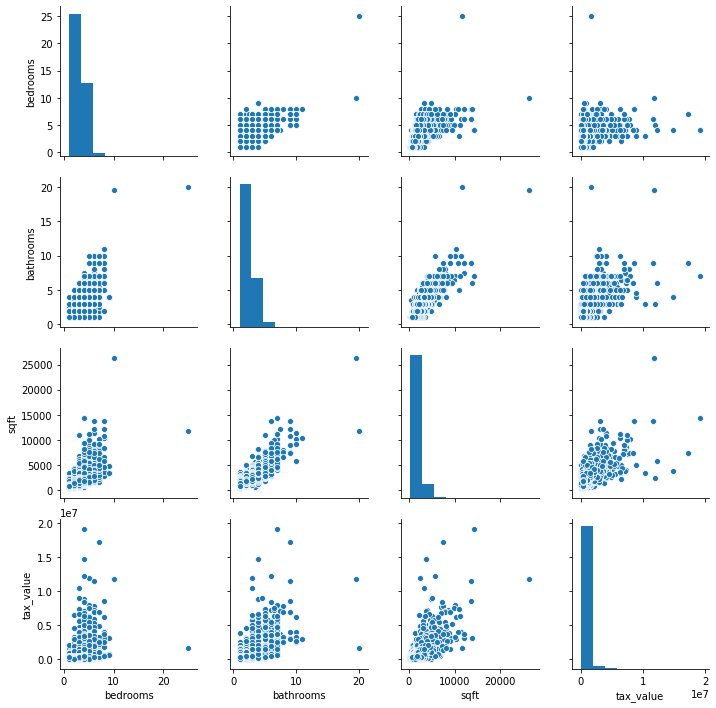

In [10]:
explore.pairplot(df_base)

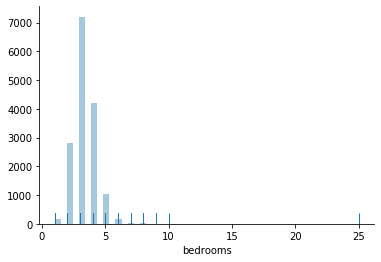

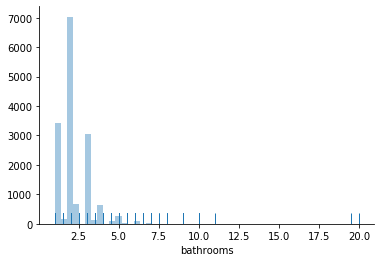

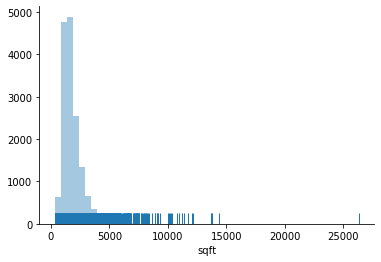

In [11]:
explore.distribution_plot(df_base)

Tax distribution by county: Orange, Ventura, and Los Angeles

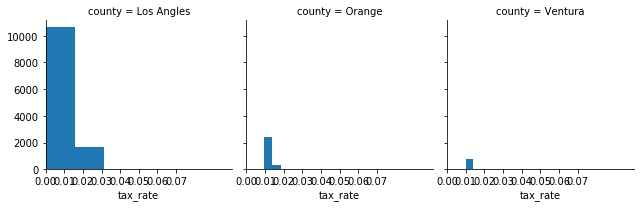

In [12]:
prep.tax_dist(df_tax)

Split and Scale
Data was split using an 80/20 train/test split set to randomstate 123

Goal: leave this section with 2 dataframes (train & test) and scaled data

In [13]:
train, test= split_scale.split_my_data(df_base, train_ratio=0.8, seed=123)

In [14]:
#labeling the train and test data
X_train = train.drop(columns='tax_value')
y_train = train[['tax_value']]
X_test = test.drop(columns='tax_value')
y_test = test[['tax_value']]

Data exploration

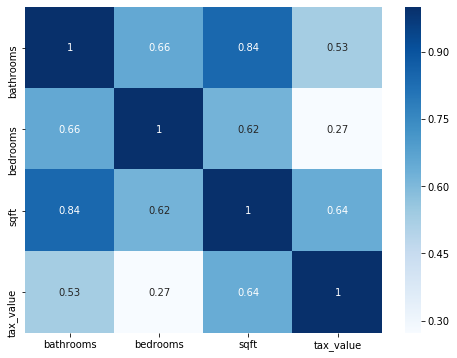

In [24]:
explore.corr_plot(train)

In [16]:
#T Test
explore.stats_test(y_train,X_train)

(Ttest_indResult(statistic=array([81.73131316]), pvalue=array([0.])),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                  OLS Regression Results                                
 Dep. Variable:              tax_value   R-squared (uncentered):                   0.635
 Model:                            OLS   Adj. R-squared (uncentered):              0.635
 Method:                 Least Squares   F-statistic:                              7277.
 Date:                Mon, 21 Oct 2019   Prob (F-statistic):                        0.00
 Time:                        02:16:05   Log-Likelihood:                     -1.8146e+05
 No. Observations:               12535   AIC:                                  3.629e+05
 Df Residuals:                   12532   BIC:                                  3.630e+05
 Df Model:                           3                                                  
 Covariance Type:            nonrobust                                         

Plotting the Resduals- based on what appears to be most correlated of the variables from the MVP requirment.

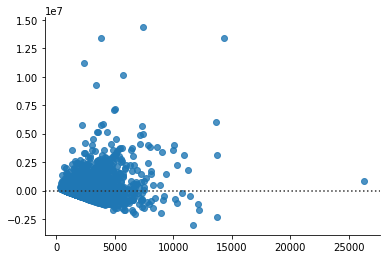

In [30]:
model.plot_residuals( df_base[['sqft']], df_base[['tax_value']])

Feature Selection

Goal: leave this section with a dataframe with the features to be used to build your model.

After running a several test for optimal features to add to this model (see Engineering notebook)
the baseline feature were optimal for finding this project

Below you will see that by grouping by fips(County) did improve the correlation. 

In [ ]:
MODELING & EVALUATION

Goal: develop a regression model that performs better than a baseline.

Modeling for the MVP- using bedrooms, bathrooms, and sqfeet

Must create a baseline to compare the MVP to. We will use the avg tax_value

In [41]:
#creating baseline with mean of tax value
train['tax_value'] = train.tax_value.mean()
train.head()

,bedrooms,bathrooms,sqft,tax_value,yhat
3396,1.0,1.0,728.0,458742.778301,214925.802417
9893,4.0,2.0,1839.0,458742.778301,348504.233813
6069,3.0,2.0,1635.0,458742.778301,395944.568526
14615,4.0,3.0,2131.0,458742.778301,526535.769063
3172,2.0,1.0,1411.0,458742.778301,393952.734547


In [42]:
#creating residual of tax value vs expected tax value
train['residual'] = train['yhat'] - train['tax_value']
train['residual2'] = train.residual **2

In [ ]:
MVP we will use the 

In [43]:
from sklearn.linear_model import LinearRegression
#pick model type, Linear Regression for the MVP baseline
lm = LinearRegression()
#fit and train model
lm.fit(X_train,y_train)
lm_y_intercept = lm.intercept_
lm_coefficients = lm.coef_

print('{} = b + m1 * {} + m2 * {}'.format(y_train.columns[0], X_train.columns[0],X_train.columns[1]))
print('    y-intercept  (b): %.2f' % lm_y_intercept)
print('    coefficient (m1): %.2f' % lm_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm_coefficients[0][1])

tax_value = b + m1 * bedrooms + m2 * bathrooms
    y-intercept  (b): -25353.09
    coefficient (m1): -143889.86
    coefficient (m2): 39976.33


In [44]:
#converting y_train Series
y_train = y_train.tax_value

In [47]:
#MSE, SSE, RMSE
import math
sse = sum(train.residual2)
mse = sse/len(train)
rmse = math.sqrt(mse)
r2 = ols_model.rsquared
print(sse,mse,rmse,r2)

2158138796829235.0 172169030461.04785 414932.5613410544 0.4395114114030475


In [20]:
base_predictions = model.modeling_function(X_train, X_test, y_train, y_test)

In [50]:
best_model=pd.DataFrame({'predictions':model2,'assessed_property_value':y_test2})

NameError: name 'model2' is not defined

Text(0.5, 1, 'Predicted vs Actual Tax Value')

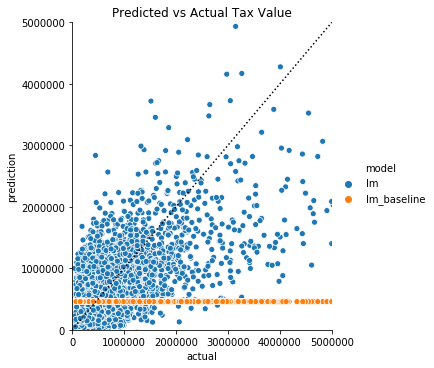

In [48]:
pd.DataFrame({'actual': y_train,
              'lm': train.yhat,
              'lm_baseline': train.tax_value})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')


min, max = 0, 5_000_000
plt.plot([min, max], [min, max], c='black', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')

In [49]:
print("R_base= ", r2)

R_base=  0.4395114114030475


In [51]:
MSE_base = mean_squared_error(base_predictions.actual_value, base_predictions.baseline)
SSE_base = MSE_base * len(base_predictions.actual_value)
RMSE_base = sqrt(MSE_base)
r2_base = r2_score(base_predictions.actual_value, base_predictions.baseline)
print(MSE_base, SSE_base, RMSE_base, r2_base)

391728237297.49286 4910313454524073.0 625881.9675445945 0.0


Conclusion from Mvp
With an R^2 value of about 44%, you can see that the Linear Regression model does better with the three choosen  features (bedrooms, bathrooms, and sqft) than the baseline model of avg tax rate.

1st feature, just using OC data

In [52]:
df_oc = df_base[df_tax.fips==6059]

In [53]:
#Split OC Data
train_oc, test_oc = split_scale.split_my_data(df_oc,train_ratio=.8,seed=123)

In [54]:
X_train_oc = train_oc.drop(columns='tax_value')
y_train_oc = train_oc[['tax_value']]
X_test_oc = test_oc.drop(columns='tax_value')
y_test_oc = test_oc[['tax_value']]

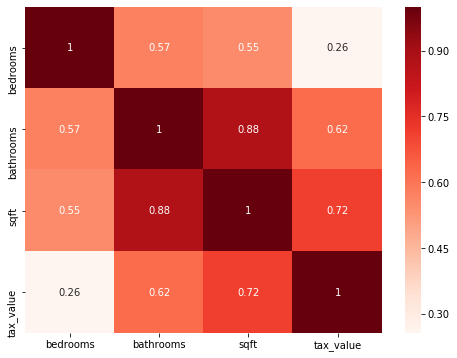

In [55]:
plt.figure(figsize=(8,6))
cor = train_oc.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [56]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#OLS object to analyze features

# ols_model = sm.OLS(y_train,X_train)
# fit = ols_model.fit()
# fit.summary()

ols_model = ols('y_train_oc ~ X_train_oc',data=train_oc).fit()
train_oc['yhat_oc'] = ols_model.predict(y_train_oc)

In [57]:
#r2 of 
r2_lm1_oc = r2_score(y_train_oc,train_oc.yhat_oc)
r2_lm1_oc

0.5400581047329245